In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
# import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
from torchvision.datasets import ImageFolder
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [24]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Resize the images

In [25]:
def transformation(img):
    resize = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor(), transforms.Grayscale()])
    i = resize(img)
    i = i * 255.0 
    return i

Import datasets

In [26]:
train_dataset = ImageFolder(root="../train", transform=transformation)
test_dataset = ImageFolder(root="../test", transform=transformation)

Split the training set in 85% for actual training set and 15% to be used as validation set

In [27]:
train_size = int(0.85 * len(train_dataset))
validation_size = len(train_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

Minibatches of size 32

In [28]:
batch_size = 32
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Network layout

In [29]:
class simpleCNN(nn.Module):  
    def __init__(self):
        super(simpleCNN, self).__init__()  

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(32 * 12 * 12, 15)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(-1, 32 * 12 * 12)  
        x = self.fc(x)
        return x

Set the initial bias values to 0 and use initial weights drawn from a Gaussian distribution having a mean of 0 and a standard deviation of 0.01

In [30]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)

In [31]:
model = simpleCNN()
model.apply(init_weights)

simpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (fc): Linear(in_features=4608, out_features=15, bias=True)
)

Employ the stochastic gradient descent with momentum optimization algorithm

In [32]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0007, momentum=0.9)

Training and Validation

In [33]:
epochs = 30

best_validation_loss = np.inf
train_losses = []
validation_losses = []
validation_accuracies = []
train_accuracies = []
for epoch in range(epochs):
    print("EPOCH {}:".format(epoch + 1))

    model.train(True)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, data in enumerate(train_loader):

        input, labels = data  

        outputs = model(input) 

        loss = loss_function(outputs, labels) 
        running_loss += (loss.item())  

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        optimizer.zero_grad()  
        loss.backward() 
        optimizer.step() 

    train_loss = running_loss / (i + 1)  
    train_accuracy = correct_predictions / total_samples

    running_validation_loss = 0.0

    model.eval()

    with torch.no_grad():  
        correct = 0
        total = 0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_function(voutputs, vlabels)
            running_validation_loss += vloss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss = running_validation_loss / (i + 1)  
    validation_acc = 100 * correct / total

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_acc)
    train_accuracies.append(train_accuracy)

    print("LOSS train {} validation {}".format(train_loss, validation_loss))
    print(f"LOSS train: {train_loss} validation: {validation_loss} | validation_accuracy: {validation_acc}% ")

    if validation_loss < best_validation_loss:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        best_validation_loss = validation_loss
        model_path = "model_{}_{}".format(timestamp, epoch)
        torch.save(model.state_dict(), model_path)

model.load_state_dict(torch.load(model_path))

EPOCH 1:
LOSS train 2.708434724807739 validation 2.7078330516815186
LOSS train: 2.708434724807739 validation: 2.7078330516815186 | validation_accuracy: 7.407407407407407% 
EPOCH 2:
LOSS train 2.708056426048279 validation 2.7077386379241943
LOSS train: 2.708056426048279 validation: 2.7077386379241943 | validation_accuracy: 0.0% 
EPOCH 3:
LOSS train 2.7077973246574403 validation 2.707665205001831
LOSS train: 2.7077973246574403 validation: 2.707665205001831 | validation_accuracy: 3.7037037037037037% 
EPOCH 4:
LOSS train 2.707682263851166 validation 2.7077927589416504
LOSS train: 2.707682263851166 validation: 2.7077927589416504 | validation_accuracy: 0.0% 
EPOCH 5:
LOSS train 2.707435005903244 validation 2.7073490619659424
LOSS train: 2.707435005903244 validation: 2.7073490619659424 | validation_accuracy: 11.11111111111111% 
EPOCH 6:
LOSS train 2.707022523880005 validation 2.707440137863159
LOSS train: 2.707022523880005 validation: 2.707440137863159 | validation_accuracy: 14.81481481481481

<All keys matched successfully>

Training and Validation Metrics

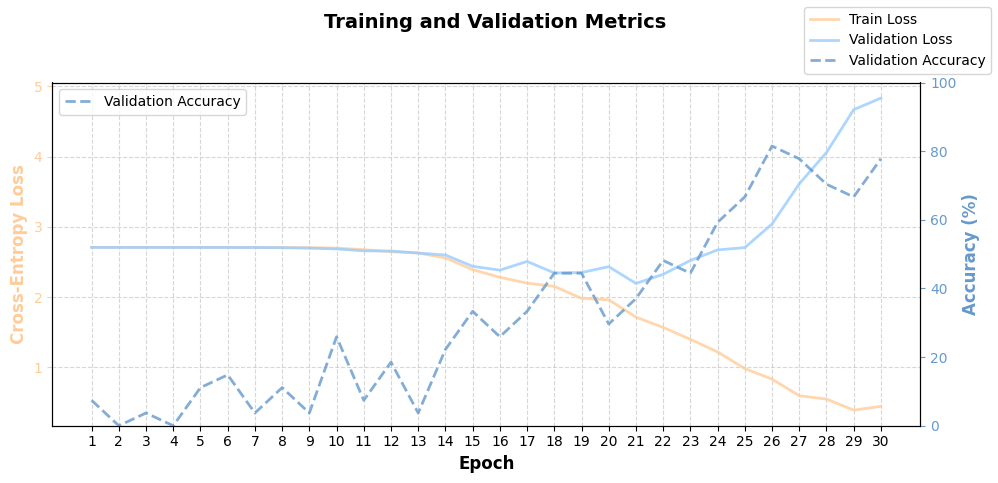

In [37]:
pastel_orange = (1.0, 0.8, 0.6)
pastel_blue = (0.6, 0.8, 1.0, 1.0) 
pastel_dark_blue = (0.4, 0.6, 0.8, 1.0)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 

ax1.plot(train_losses, color=pastel_orange, linewidth=2, label="Train Loss", alpha=0.8)
validation_losses_np = torch.stack(validation_losses).cpu().numpy()
ax1.plot(
    validation_losses_np,
    color=pastel_blue,
    linewidth=2,
    label="Validation Loss",
    alpha=0.8,
)

ax1.set_xlabel("Epoch", fontsize=12, fontweight="bold")
ax1.set_ylabel(
    "Cross-Entropy Loss", fontsize=12, fontweight="bold", color=pastel_orange
)
ax1.tick_params(axis="y", colors=pastel_orange)
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.set_xticks(range(len(train_losses)))  
ax1.set_xticklabels(
    range(1, len(train_losses) + 1)
)  
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)

ax2.plot(
    validation_accuracies,
    color=pastel_dark_blue,
    linestyle="--",
    linewidth=2,
    label="Validation Accuracy",
    alpha=0.8,
)

ax2.set_ylabel("Accuracy (%)", fontsize=12, fontweight="bold", color=pastel_dark_blue)
ax2.tick_params(axis="y", colors=pastel_dark_blue)
ax2.set_ylim(0, 100)  
ax2.legend(loc="upper left", fontsize=10)

fig.legend(loc="upper right", fontsize=10)
fig.set_size_inches(10, 5)

fig.suptitle("Training and Validation Metrics", fontsize=14, fontweight="bold")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Test and Accuracy

In [35]:
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)  # Save Prediction
        y_true.extend(labels)  # Save Truth

print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")

Accuracy of the network on the test images: 27.20%


Confusion matrix

<Axes: >

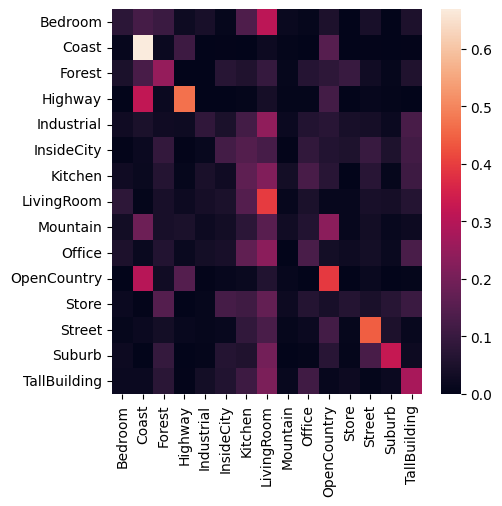

In [39]:
classes = test_dataset.classes
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
    index=[i for i in classes],
    columns=[i for i in classes],
)
plt.figure(figsize=(5, 5))
sn.heatmap(df_cm)